In [1]:
import os
import csv
import struct
import numpy as np
import math
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt


In [2]:
show_plots = True
show_events_plots = True


event_stereotype_file_path = '/home/luca/py-scripts/event_stereotype_stored'
# event_stereotype_file_path =  os.path.join("C:\\","Users", "Luca Rossi", "Desktop","py-scripts", "event_stereotype_stored")

root_folder = r"/home/luca/Desktop/SARS-CoV"
# root_folder = os.path.join("C:\\","Users", "Luca Rossi", "Desktop", "extracted events")
event_folders = [root_folder + os.sep + d for d in os.listdir(root_folder)]

In [3]:
def open_dat(filename):
    f = open(filename, "rb")
    f_cont = f.read()
    f.close()
    raw = struct.unpack("d" * (len(f_cont) // 8), f_cont)
    return np.array(raw)

In [4]:
def extract_lengths(filename):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        events_lengths = []
        for row in csv_reader:
            if len(row) > 1:
                if line_count > 2:
                    events_lengths.append(int(row[1]) - int(row[0]))
            line_count+=1
        return events_lengths

In [5]:
def analyze(dir_name, event_stereotype_stored = None, mean_std_amp = None, mean_std_d50s = None, sw_th = None, sf_th = None ):
    tot=0
    SF = []
    SW = []
    amplitudes = []
    d50s = []
    stereotype_length = 35
    files = os.listdir(dir_name)
    experiment_name = dir_name
    dat_file = [dir_name + os.sep + f for f in files if f.endswith(".dat")].pop()
    details_file = [dir_name + os.sep + f for f in files if f.endswith(".csv")].pop()
    
    # caricamento eventi dal singolo file    
    events = open_dat(dat_file)
    # caricamento dettagli file
    events_length = extract_lengths(details_file)

    good_events_n = 0
    event_avg = np.zeros(34)

    if len([e for e in events_length if e >= 35]) == 0:
        print("0 events", details_file)
        return event_avg, good_events_n

    b = 0
    # ciclo sulle lunghezze degli eventi
    if show_events_plots:
        fig, ax = plt.subplots()
        ax.set_title(dir_name)
    for ev_len in events_length:
        tot +=1
        # scarto eventi troppo brevi
        if ev_len < 35:
            continue
        e = b + ev_len
        event = events[b:e]
        b = e

        # calcolo la baseline sul primo 20% del primo terzo dei dati e
        # sull'ultimo 20% dell'ultimo terzo dei dati
        x_baseline = np.concatenate((event[:round(ev_len/3*0.2)], event[round(ev_len - ev_len/3*0.2):]))
        baseline = np.mean(x_baseline)
        amplitude = baseline - event.min()
        event_50 = np.nonzero(event < baseline - amplitude / 2)[0]
        # istante in cui l'evento supera il 50% dell'escursione
        b50 = event_50[0]
        # istante in cui l'evento torna al di sotto del 50% dell'escursione
        e50 = event_50[-1]
        d50 = e50 - b50
        if d50 <=0:
            continue
        # forma d'onda normalizzata:
        # in ampiezza dividendo per amplitude
        # in durata facendo la spline su un numero fisso di campioni
        x = [x for x in range(ev_len)]
        x_norm = np.linspace(0, ev_len-1, stereotype_length*3+4)
        f = CubicSpline(x, event/amplitude)
        event_norm = f(x_norm)
        event_norm = event_norm[stereotype_length+3:2*stereotype_length+2]
        if event_stereotype_stored is not None:
            mean_amps, std_amps = mean_std_amp 
            mean_d50s, std_d50s = mean_std_d50s
            # faccio il logaritmo di ampiezze e durate perchè gli istogrammi in
            # scala logaritmica sono più simmetrici
            # inoltre faccio un whitening semplificato: sottraggo la media e
            # divido per la deviazione standard calcolate in un'esecuzione precedente
            SA = (math.log(amplitude)-mean_amps)/std_amps
            SD = (math.log(d50)-mean_d50s)/std_d50s
            sf = math.sqrt(pow(SA,2)+pow(SD,2))
            sw = math.sqrt(np.sum(np.power((event_norm-event_stereotype_stored),2)))
            if sw < sw_th and sf < sf_th:
                SF.append(sf)
                SW.append(sw)
                amplitudes.append(amplitude)
                d50s.append(d50)
                event_avg += event_norm
                good_events_n+=1
                # plt.plot(event_norm)
        else:
            amplitudes.append(amplitude)
            d50s.append(d50)
            event_avg += event_norm
            good_events_n+=1
        if show_events_plots:
            ax.plot(event_norm)

    if show_events_plots and not ax.lines:
        plt.close(fig=fig)
    return event_avg, good_events_n, SF, SW, amplitudes, d50s, tot

    # event_avg = event_avg / good_events_n


/tmp/ipykernel_16687/2374632983.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


total events are 922
good events are 887 0.9620390455531453
-21.288050274695433 0.6804747864784267
4.238999821508672 1.3414024535796811


NameError: name 'event_stereotype_stored' is not defined

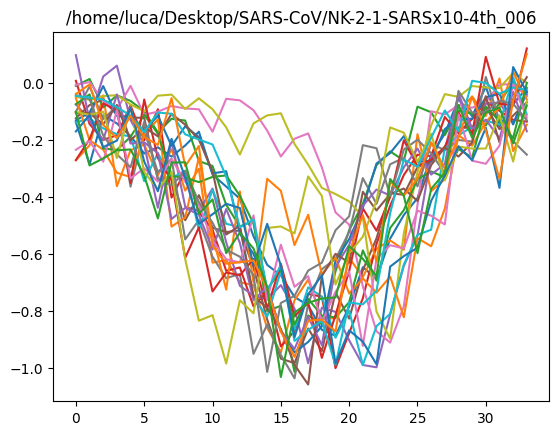

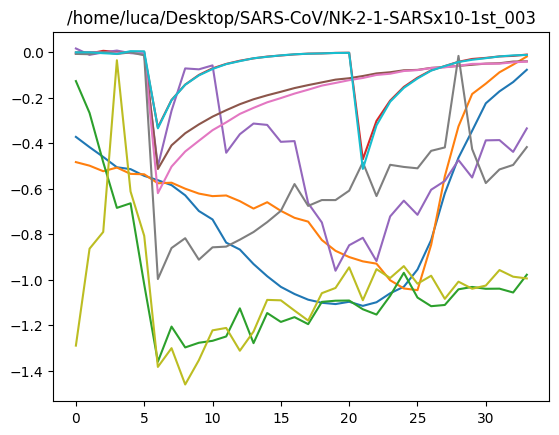

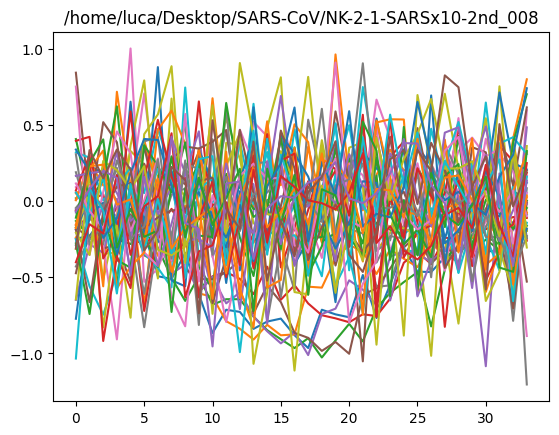

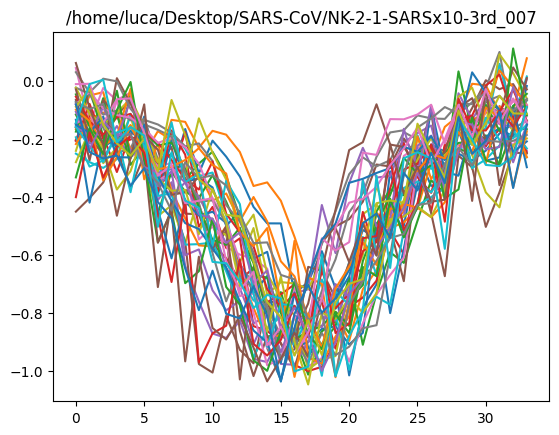

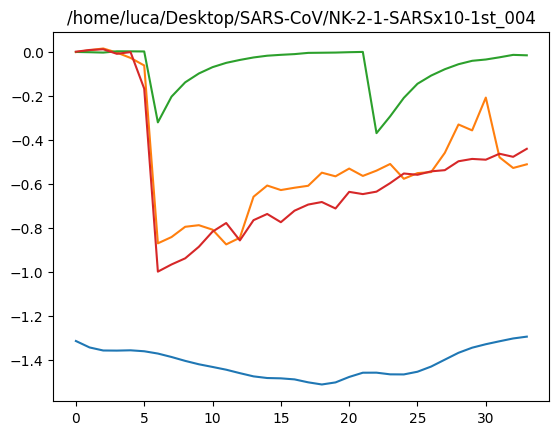

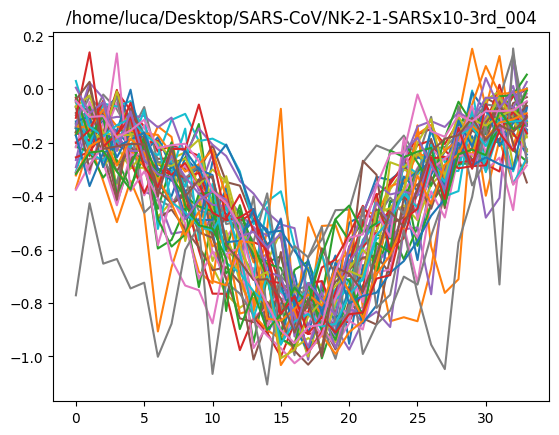

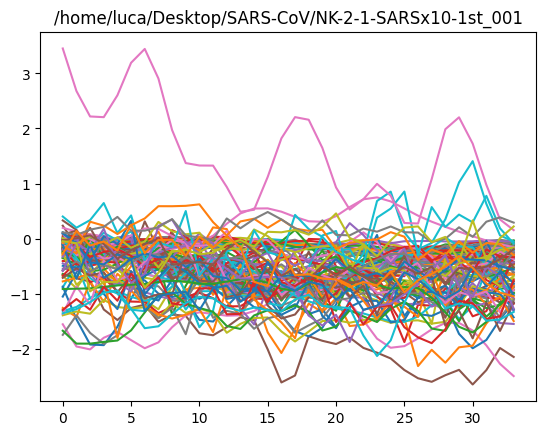

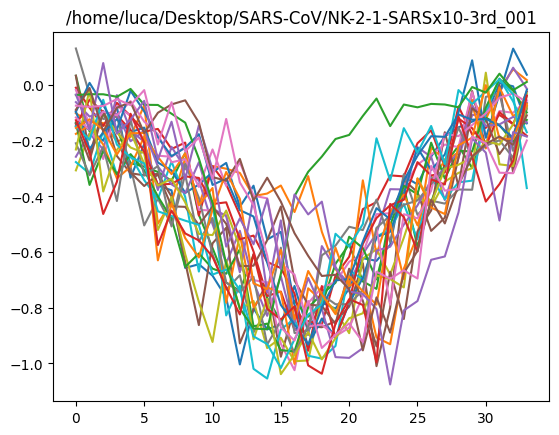

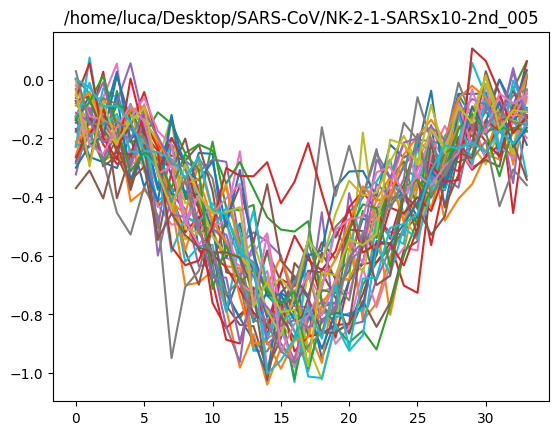

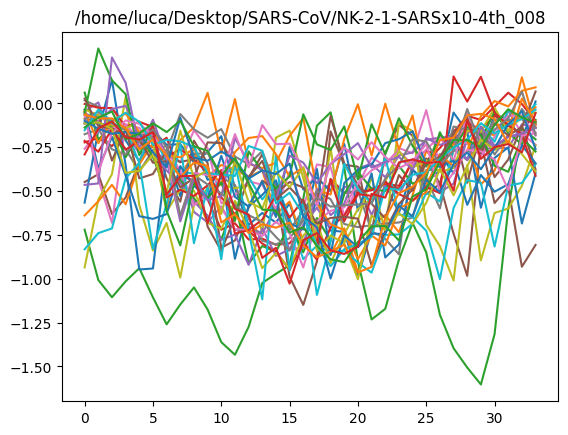

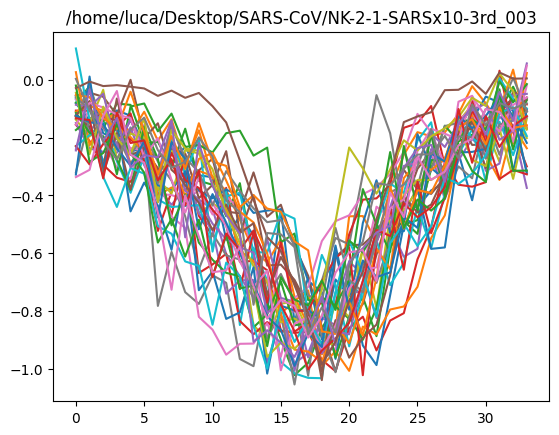

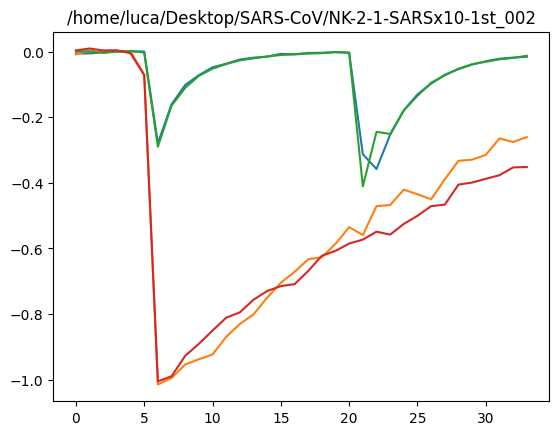

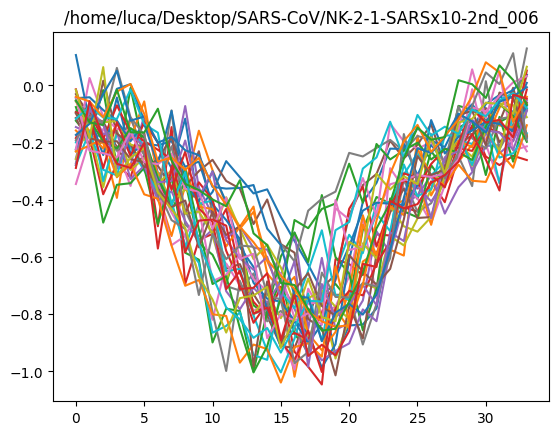

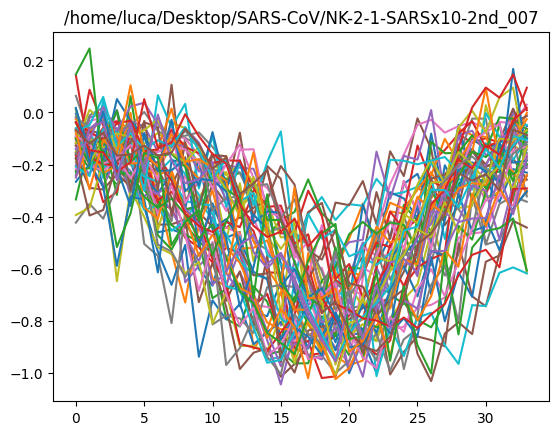

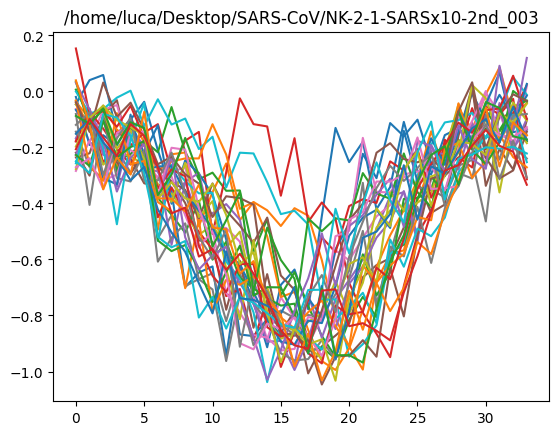

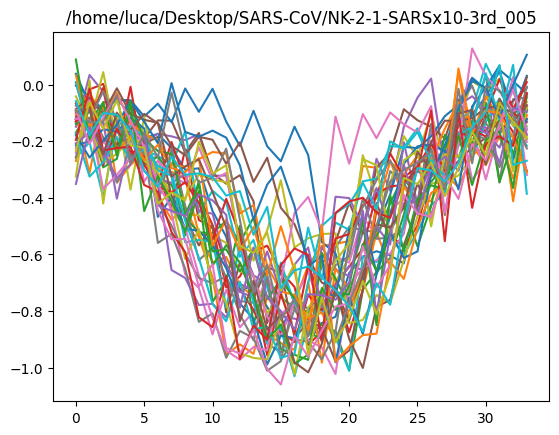

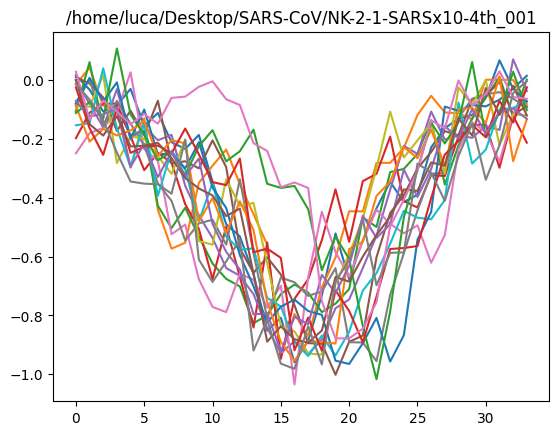

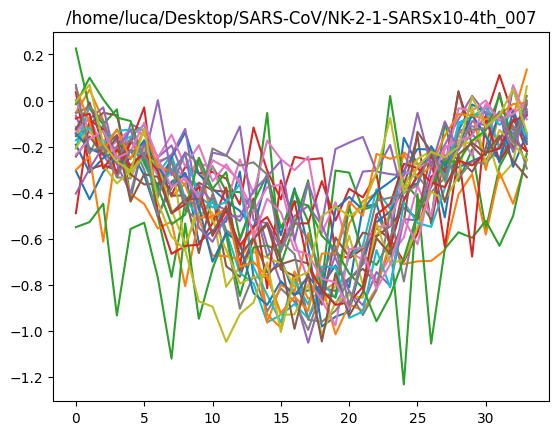

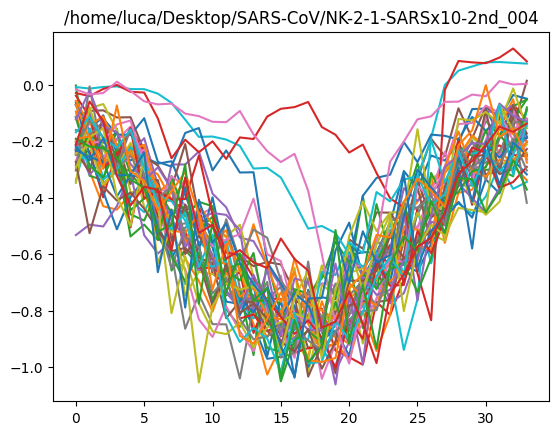

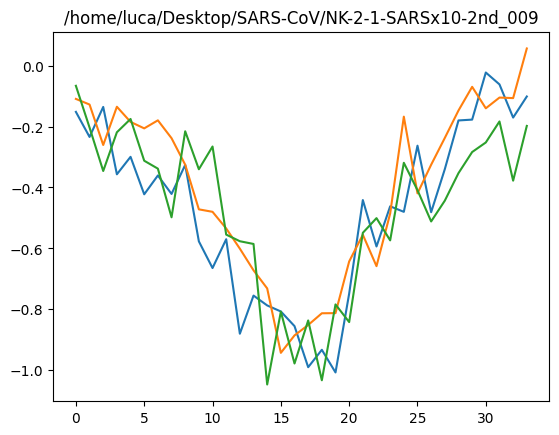

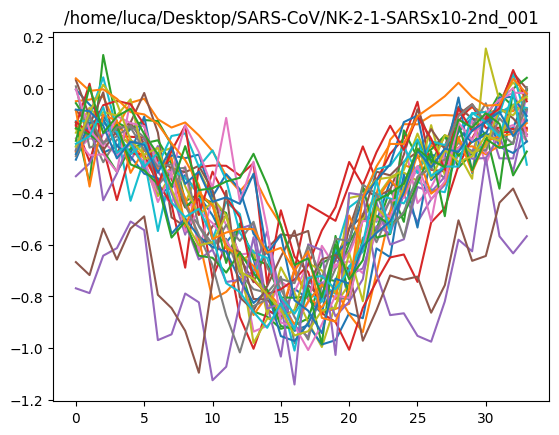

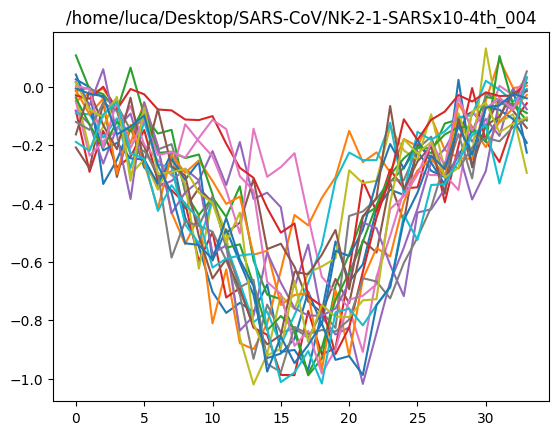

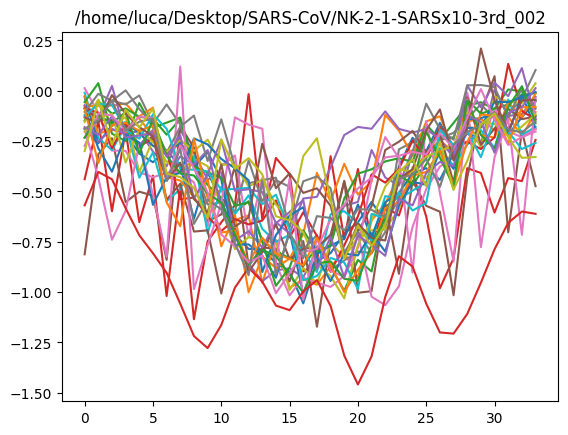

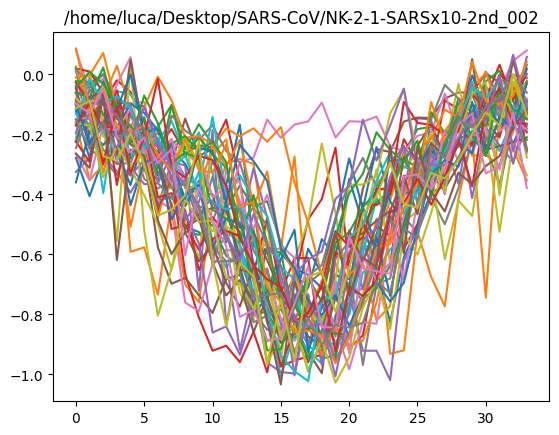

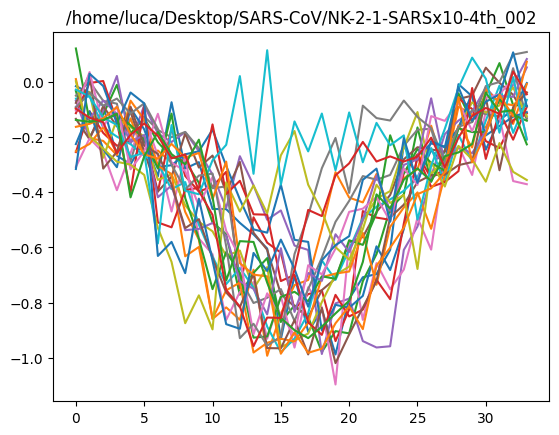

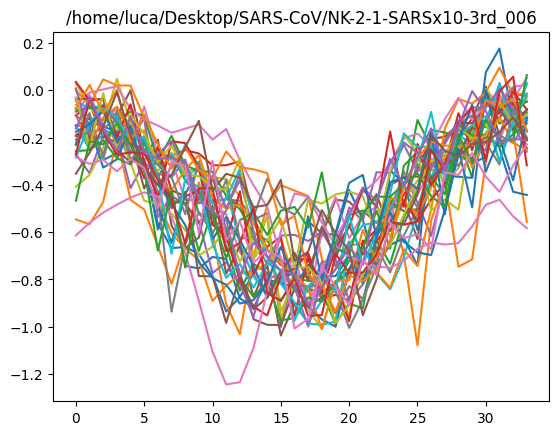

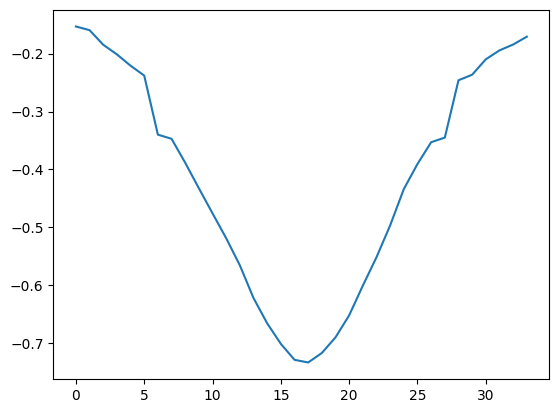

In [6]:
#First run
good_events_tot = 0
event_stereotype = np.zeros(34)

tot= 0

amplitudes = []
d50s = []

for event in event_folders:
    event_avg, good_events_n, SF_partial, SW_partial, amplitudes_partial, d50s_partial,tot_n = analyze(event)
    event_stereotype += event_avg
    good_events_tot += good_events_n
    amplitudes += amplitudes_partial
    d50s += d50s_partial
    tot += tot_n
    
print("total events are", tot)
print("good events are", good_events_tot, good_events_tot/tot)

event_stereotype = event_stereotype / good_events_tot
np.savetxt(event_stereotype_file_path, event_stereotype)
log_amplitudes = np.log(amplitudes)

mean_amplitudes = np.mean(log_amplitudes)
std_amplitudes = np.std(log_amplitudes)

print(mean_amplitudes, std_amplitudes)
log_d = np.log(d50s)

mean_d50s = np.mean(log_d) 
std_d50s = np.std(log_d)
print(mean_d50s, std_d50s )
if show_plots:
    fig, ax = plt.subplots()
    ax.plot(event_stereotype) 
    ax.plot(event_stereotype_stored, "--") 
    fig, ax = plt.subplots()
    ax.loglog(amplitudes, d50s, 'o')
#     fig, ax = plt.subplots()
#     ax.hist(SF, 30)
#     ax.set_title("SF")
#     fig, ax = plt.subplots()
#     ax.set_title("SW")
#     ax.hist(SW, 30)
    plt.show()

In [ ]:
mean_std_amps = (mean_amplitudes, std_amplitudes) 
mean_std_d50s = (mean_d50s, std_d50s) 

tot= 0

good_events_tot = 0
SF = []
SW = []
amplitudes_othre_run = []
d50s_othre_run = []

event_stereotype_stored = np.loadtxt(event_stereotype_file_path) if os.path.exists(event_stereotype_file_path) else None

for event in event_folders:
    event_avg, good_events_n, SF_partial, SW_partial, amplitudes_partial, d50s_partial, tot_n = analyze(event, event_stereotype_stored, mean_std_amps, mean_std_d50s, 0.8, 0.6)
    event_stereotype += event_avg
    good_events_tot += good_events_n
    SF += SF_partial
    SW += SW_partial
    amplitudes_othre_run += amplitudes_partial
    d50s_othre_run += d50s_partial
    tot += tot_n

print("total events are", tot)
print("good events are", good_events_tot, good_events_tot/tot)
event_stereotype = event_stereotype / good_events_tot
np.savetxt(event_stereotype_file_path, event_stereotype)
log_amplitudes = np.log(amplitudes_othre_run)
print(np.mean(log_amplitudes), np.std(log_amplitudes))
log_d = np.log(d50s_othre_run)
print(np.mean(log_d), np.std(log_d))
if show_plots:
    fig, ax = plt.subplots()
    ax.plot(event_stereotype) 
    ax.plot(event_stereotype_stored, "--") 
    fig, ax = plt.subplots()
    ax.loglog(amplitudes_othre_run, d50s_othre_run, 'o')
    fig, ax = plt.subplots()
    ax.hist(SF, 30)
    ax.set_title("SF")
    fig, ax = plt.subplots()
    ax.set_title("SW")
    ax.hist(SW, 30)
    plt.show()